In [1]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines


In [2]:
#### Get WIGOS IDs for all stations catalogued in a country ####

country = "KEN"

# API: all stations as json
all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName="+country


response = urlopen(all_stations_KEN_url)
data_json = json.loads(response.read())
stations = data_json["stationSearchResults"]

wigosIds = []

for station in data_json["stationSearchResults"]:
    # print(station["wigosId"])
    wigosId = str(station["wigosId"])
    wigosIds.append(wigosId)

print(wigosIds)

['0-404-300-301570787AS00074', '0-404-300-402261127AS63663', '0-404-300-271440721AS00049', '0-404-300-281480740AS00057', '0-404-0-63707', '0-404-300-392191090AS63662', '0-404-0-63721', '0-404-300-040200100AS00113', '0-404-300-040200098AS00112', '0-404-300-301620807AS00073', '0-404-300-301580790AS00071', '0-404-300-402251125AS00038', '0-404-300-402281141AS00036', '0-404-300-402291146AS00033', '0-404-300-392181085AS63660', '0-404-300-361950974AS00015', '0-20000-0-63741', '0-404-300-472781389AS63747', '0-404-300-100470235AS00114', '0-404-300-372081037AS00024', '0-404-300-372000999AS00025', '0-404-300-372031019AS00022', '0-404-300-372101048AS00026', '0-20000-0-63688', '0-404-300-63686', '0-20000-0-63720', '0-404-0-63719', '0-404-300-341870932AS00005', '0-404-300-341840918A00001', '0-404-300-050210101AS00090', '0-404-0-63670', '0-20000-0-63723', '0-404-300-190950473AS00101', '0-404-300-060230111AS00047', '0-404-300-190950476AS00099', '0-404-300-070320150AS00107', '0-404-300-341840918AS00001

In [4]:
for id in wigosIds:
    print(id)

0-404-300-301570787AS00074
0-404-300-402261127AS63663
0-404-300-271440721AS00049
0-404-300-281480740AS00057
0-404-0-63707
0-404-300-392191090AS63662
0-404-0-63721
0-404-300-040200100AS00113
0-404-300-040200098AS00112
0-404-300-301620807AS00073
0-404-300-301580790AS00071
0-404-300-402251125AS00038
0-404-300-402281141AS00036
0-404-300-402291146AS00033
0-404-300-392181085AS63660
0-404-300-361950974AS00015
0-20000-0-63741
0-404-300-472781389AS63747
0-404-300-100470235AS00114
0-404-300-372081037AS00024
0-404-300-372000999AS00025
0-404-300-372031019AS00022
0-404-300-372101048AS00026
0-20000-0-63688
0-404-300-63686
0-20000-0-63720
0-404-0-63719
0-404-300-341870932AS00005
0-404-300-341840918A00001
0-404-300-050210101AS00090
0-404-0-63670
0-20000-0-63723
0-404-300-190950473AS00101
0-404-300-060230111AS00047
0-404-300-190950476AS00099
0-404-300-070320150AS00107
0-404-300-341840918AS00001
0-404-300-160810398AS00009
0-404-300-070320160AS00106
0-20000-0-63740
0-20000-0-63687
0-404-300-372021012AS63

In [5]:
#### create json file #####
 
j_data = '{"stations":[]}' 

file = open("stations.json", "w")
file.write(j_data)
file.close()


In [6]:
#### append information to json file ####

def write_json(new_data, filename='stations.json'):
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["stations"].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [7]:
#### Get station xml Files via jOAI ####

for id in wigosIds:

    # get url
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id

    # get xml from url
    document = requests.get(url)
    soup= BeautifulSoup(document.content,"xml")

    #### get information to plot ####

    metadata = soup.find('metadata') #check if xml file is available on jOAI
    if metadata:

        # Name
        name = soup.find_all('name')
        name = re.findall(r'.*?\>(.*)\<.*',str(name))

        # Location
        location = soup.find_all('pos')
        location = re.findall(r'.*?\>(.*)\<.*',str(location))[0]
        loc = re.findall(r'-?[0-9]*\.?[0-9]*', location)
        
        lat = loc[0]
        lon = loc[2]
        if len((loc)) == 6: # check if elevation is given
            ele = loc[4]
        else:
            ele = "unknown"
       
        # observed Variables
        observedProperties = soup.find_all('observedProperty')
        observedProperties_notation = re.findall(r'\d+',str(observedProperties))
            
        # begin Position
        beginPosition = soup.find_all('beginPosition')
        beginPosition = re.findall(r'\d{4}-\d{2}-\d{2}',str(beginPosition))[0]
        # print(beginPosition)

        # ReportingStatus
        reportingStatus = soup.find('reportingStatus')
        if reportingStatus:
            reportingStatus = soup.find_all('reportingStatus')
            reportingStatus = re.findall(r'http://codes.wmo.int/wmdr/ReportingStatus/(.*)\"\s.*',str(reportingStatus))[0]
        else:
            reportingStatus = "unknown"
        

        #### save to json File ####
        aDict = {"wigosId" : id, "name":name, "lat":lat, "lon":lon, "ele":ele, "observedProperties" : observedProperties_notation, "beginPosition" : beginPosition, "reportingStatus" : reportingStatus}
        print(aDict)
        write_json(aDict)
   

{'wigosId': '0-404-300-301570787AS00074', 'name': ['AIC Churo Girls  High School'], 'lat': '0.7668', 'lon': '36.4056', 'ele': '1798.0', 'observedProperties': ['210', '216', '224', '251', '12005', '12006'], 'beginPosition': '2021-11-29', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-402261127AS63663', 'name': ['ALUPE'], 'lat': '0.497', 'lon': '34.1252', 'ele': 'unknown', 'observedProperties': ['210', '210', '216', '224', '225', '230', '251', '12005', '12006'], 'beginPosition': '2020-09-22', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-271440721AS00049', 'name': ['Ainabkoi KCC Plant'], 'lat': '0.1601', 'lon': '35.5204', 'ele': '2635.0', 'observedProperties': ['210', '216', '224', '251', '12005', '12006'], 'beginPosition': '2021-11-18', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-281480740AS00057', 'name': ['Arror Irrigation scheme (Agromet)'], 'lat': '0.9388', 'lon': '35.625', 'ele': '1034.0', 'observedProperties': ['210', '216', '224', '251', '12005',

In [8]:
# Load map background
m = Basemap(projection='lcc', resolution='h', 
            lat_0=0.1, lon_0=37.5,
            width=1.5E6, height=1.2E6)

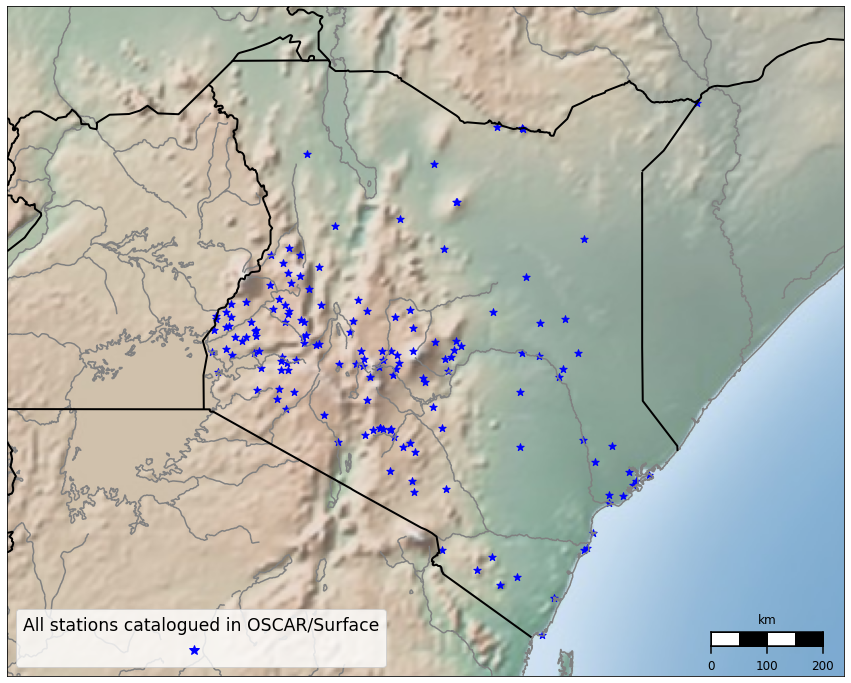

In [9]:
#### DRAW MAP of all stations ####

fig = plt.figure(figsize=(15, 15))


# map background
# m.fillcontinents(color='tan',lake_color='lightblue')
m.shadedrelief()
# m.etopo()
# m.bluemarble()
m.drawmapscale(lon=43, lat=-4.7, lon0=43,lat0=-4, length=200, barstyle="fancy", linecolor="black", fillcolor2="black", fontsize=12, fontcolor="black")
m.drawcoastlines(color='grey', linewidth=1.5)
m.drawrivers(color='grey', linewidth=1.5)
m.drawcountries(color='black', linewidth=2)
# m.drawlsmask(land_color='0.8', ocean_color='w', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5)
# m.drawmapboundary(color='k', linewidth=1.0, fill_color=None, zorder=None, ax=None)



# f = open('data.json')
# data = json.load(f)

f = open(os.getcwd()+'/stations.json')
data = json.load(f)

for i in data['stations']:
    # print(float(i["lat"]))
    lat = float(i["lat"])
    lon = float(i["lon"])
    m.scatter(lon, lat,latlon=True,c="blue",s=60,marker="*")


# legend
stations = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',markersize=10)
plt.legend(handles=[stations], loc=3, title="All stations catalogued in OSCAR/Surface", title_fontsize="xx-large", labelcolor="black", fontsize="xx-large")


# save plot
plt.savefig(os.getcwd()+"/Plots/all_stations_catalogued.pdf", bbox_inches='tight')

In [12]:
f = open(os.getcwd()+'/stations.json')
data = json.load(f)

data["stations"][1]["observedProperties"]


['210', '210', '216', '224', '225', '230', '251', '12005', '12006']

In [13]:
df = pd.DataFrame(data["stations"])
# print(df)
df[["lat", "lon", "beginPosition", "reportingStatus"]]


,lat,lon,beginPosition,reportingStatus
0,0.7668,36.4056,2021-11-29,operational
1,0.497,34.1252,2020-09-22,operational
2,0.1601,35.5204,2021-11-18,operational
3,0.9388,35.625,2021-11-29,operational
4,-0.714732,35.3833,2020-09-21,preOperational
...,...,...,...,...
154,3.596,55.34,2014-03-28,closed
155,5.97,49.433,2014-09-07,closed
156,-3.474,54.023,2009-06-25,closed
157,-7.107,57.804,2011-11-16,closed


In [15]:
for i in df[["lat"]]:
    print(i)
print (df['reportingStatus'].unique())

lat
['operational' 'preOperational' 'unknown' 'closed' 'nonReporting']


dict_items([('operational', 'tab:blue'), ('preOperational', 'tab:purple'), ('unknown', 'tab:grey'), ('closed', 'tab:red'), ('nonReporting', 'tab:orange')])


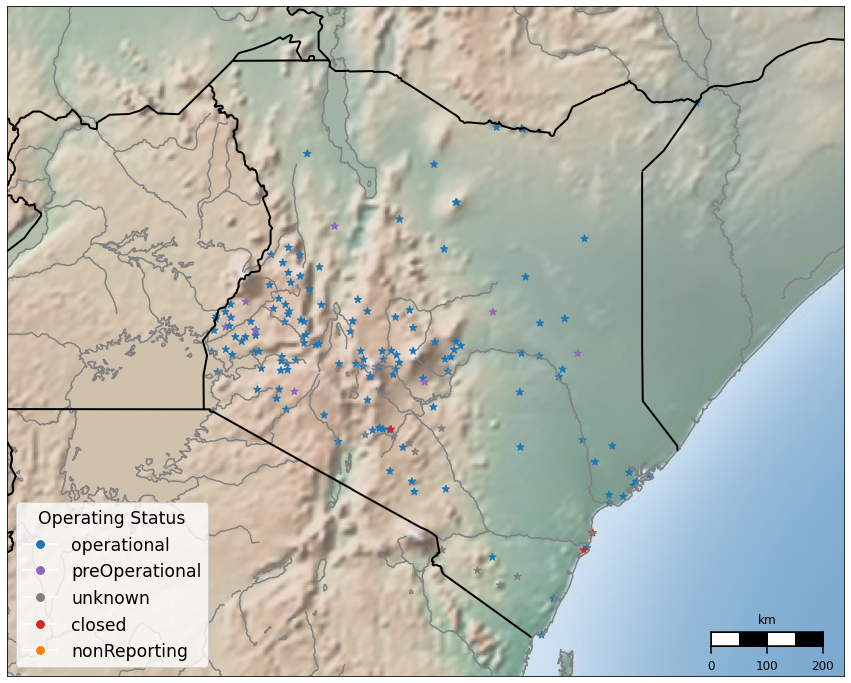

In [16]:
#### DRAW MAP of all stations ####

fig = plt.figure(figsize=(15, 15))

# map background
# m.fillcontinents(color='tan',lake_color='lightblue')
m.shadedrelief()
# m.etopo()
# m.bluemarble()
m.drawmapscale(lon=43, lat=-4.7, lon0=43,lat0=-4, length=200, barstyle="fancy", linecolor="black", fillcolor2="black", fontsize=12, fontcolor="black")
m.drawcoastlines(color='grey', linewidth=1.5)
m.drawrivers(color='grey', linewidth=1.5)
m.drawcountries(color='black', linewidth=2)
# m.drawlsmask(land_color='0.8', ocean_color='w', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5)
# m.drawmapboundary(color='k', linewidth=1.0, fill_color=None, zorder=None, ax=None)

# f = open('data.json')
# data = json.load(f)

f = open(os.getcwd()+'/stations.json')
data = json.load(f)

# for i in data['stations']:
#     # print(float(i["lat"]))
colors = {'operational':'tab:blue', 'preOperational':'tab:purple', 'unknown':'tab:grey', 'closed':'tab:red', 'nonReporting':'tab:orange'}
print(colors.items())

lat = df["lat"]
lon = df["lon"]
m.scatter(lon, lat,latlon=True,c=df["reportingStatus"].map(colors),s=60,marker="*")


# legend
stations = [mlines.Line2D([0], [0], color="w", marker='o',markersize=10,  markerfacecolor=v, label=k) for k, v in colors.items()]
plt.legend(handles=stations, loc=3, title="Operating Status", title_fontsize="xx-large", labelcolor="black", fontsize="xx-large")


# save plot
plt.savefig(os.getcwd()+"/Plots/all_stations_reportingStatus.pdf", bbox_inches='tight')

In [17]:
df = pd.DataFrame(data["stations"])
# print(df)
df[["lat", "lon", "beginPosition", "reportingStatus"]]

min(df["beginPosition"]) #'1958-03-09'
max(df["beginPosition"]) # 2022-12-01


'2022-12-01'

In [18]:
for date in df["beginPosition"]:
    if (date < "1961-01-01"):
        print("1: ", date)
    if (date >= "1961-01-01") & (date < "1970-01-01"):
        print("2: ",date)
    if (date >= "1971-01-01") & (date < "1980-01-01"):
        print("3: ",date)
    if (date >= "1981-01-01") & (date < "1990-01-01"):
        print("4: ",date)
    if (date >= "1991-01-01") & (date < "2000-01-01"):
        print("5: ",date)
    if (date >= "2001-01-01") & (date < "2010-01-01"):
        print("6: ",date)
    if (date >= "2011-01-01") & (date < "2020-01-01"):
        print("7: ",date)
    if (date >= "2021-01-01"):
        print("8: ",date)



8:  2021-11-29
8:  2021-11-18
8:  2021-11-29
8:  2022-01-24
8:  2022-01-21
8:  2021-11-29
8:  2021-11-27
8:  2021-11-13
8:  2021-11-12
8:  2021-11-11
8:  2021-10-24
7:  2016-04-28
8:  2021-12-16
8:  2021-11-15
8:  2021-11-16
8:  2021-11-16
8:  2021-11-15
7:  2016-04-28
7:  2016-04-28
7:  2016-04-28
8:  2021-09-19
8:  2021-09-16
8:  2022-01-02
7:  2016-04-28
8:  2021-12-12
8:  2021-10-19
8:  2021-10-12
8:  2022-01-20
8:  2022-04-13
8:  2021-11-12
8:  2022-01-20
1:  1958-03-09
7:  2016-04-28
8:  2021-10-14
8:  2021-04-11
8:  2021-11-04
7:  2016-04-28
8:  2021-06-12
8:  2021-12-03
7:  2016-04-28
7:  2016-04-28
7:  2016-04-28
8:  2021-12-16
8:  2021-11-22
8:  2021-11-21
8:  2021-11-24
8:  2021-10-22
8:  2021-11-18
8:  2021-11-24
8:  2022-10-01
8:  2021-10-13
8:  2021-10-08
8:  2021-11-12
8:  2021-09-12
8:  2021-09-12
8:  2021-12-19
8:  2021-11-03
8:  2021-11-28
8:  2021-11-17
7:  2016-04-28
8:  2022-12-01
8:  2021-10-28
8:  2021-10-12
7:  2016-04-28
7:  2016-04-28
7:  2016-04-28
7:  2016-0

In [19]:
df[df["beginPosition"] < "1960-01-01"]

df[(df["beginPosition"] >= "1990-01-01") & (df["beginPosition"] < "2000-01-01")]

,wigosId,name,lat,lon,ele,observedProperties,beginPosition,reportingStatus
98,0-20008-0-MKN,"[Mt. Kenya</gml:name>, <gml:name>Mount Kenya]",-0.0621999986,37.2971992493,unknown,"[248, 192, 194, 195, 196, 201, 203, 251, 205, ...",1999-01-01,operational
110,0-20008-0-NRB,[Nairobi],-1.30169,36.75919,unknown,"[263, 263, 263, 264, 264, 264, 264, 573, 325]",1996-01-01,operational


In [20]:
for date in df["beginPosition"]:
    if (date < "1960-01-01"):
        print("1: ", date)
    if (date >= "1961-01-01") & (date < "1971-01-01"):
        print("2: ",date)
    if (date >= "1971-01-01") & (date < "1981-01-01"):
        print("3: ",date)
    if (date >= "1981-01-01") & (date < "1991-01-01"):
        print("4: ",date)
    if (date >= "1991-01-01") & (date < "2001-01-01"):
        print("5: ",date)
    if (date >= "2001-01-01") & (date < "2011-01-01"):
        print("6: ",date)
    if (date >= "2011-01-01") & (date < "2021-01-01"):
        print("7: ",date)
    if (date >= "2021-01-01"):
        print("8: ",date)


start_d = ["1961-01-01", "1971-01-01", "1981-01-01", "1991-01-01", "2001-01-01", "2011-01-01", "2021-01-01"]


8:  2021-11-29
7:  2020-09-22
8:  2021-11-18
8:  2021-11-29
7:  2020-09-21
7:  2020-09-21
7:  2020-09-21
8:  2022-01-24
8:  2022-01-21
8:  2021-11-29
8:  2021-11-27
8:  2021-11-13
8:  2021-11-12
8:  2021-11-11
7:  2020-09-21
8:  2021-10-24
7:  2016-04-28
7:  2020-09-21
8:  2021-12-16
8:  2021-11-15
8:  2021-11-16
8:  2021-11-16
8:  2021-11-15
7:  2016-04-28
7:  2016-04-28
7:  2016-04-28
7:  2020-09-21
8:  2021-09-19
8:  2021-09-16
8:  2022-01-02
7:  2020-09-21
7:  2016-04-28
8:  2021-12-12
8:  2021-10-19
8:  2021-10-12
8:  2022-01-20
8:  2022-04-13
8:  2021-11-12
8:  2022-01-20
1:  1958-03-09
7:  2016-04-28
7:  2020-09-21
8:  2021-10-14
8:  2021-04-11
8:  2021-11-04
7:  2016-04-28
8:  2021-06-12
8:  2021-12-03
7:  2016-04-28
7:  2016-04-28
7:  2016-04-28
8:  2021-12-16
8:  2021-11-22
8:  2021-11-21
8:  2021-11-24
8:  2021-10-22
8:  2021-11-18
8:  2021-11-24
8:  2022-10-01
8:  2021-10-13
8:  2021-10-08
8:  2021-11-12
8:  2021-09-12
8:  2021-09-12
8:  2021-12-19
8:  2021-11-03
8:  2021-1

In [25]:
start_d = ["1951-01-01", "1961-01-01", "1971-01-01", "1981-01-01", "1991-01-01", "2001-01-01", "2011-01-01", "2021-01-01", "2031-01-01"]

for i in range(0,8):
    print(start_d[i])
    df = df[(df["beginPosition"] >= start_d[i]) & (df["beginPosition"] < start_d[i+1])]
    print(df[["lon"]])

1951-01-01
Empty DataFrame
Columns: [lon]
Index: []
1961-01-01
Empty DataFrame
Columns: [lon]
Index: []
1971-01-01
Empty DataFrame
Columns: [lon]
Index: []
1981-01-01
Empty DataFrame
Columns: [lon]
Index: []
1991-01-01
Empty DataFrame
Columns: [lon]
Index: []
2001-01-01
Empty DataFrame
Columns: [lon]
Index: []
2011-01-01
Empty DataFrame
Columns: [lon]
Index: []
2021-01-01
Empty DataFrame
Columns: [lon]
Index: []


In [107]:
df = pd.DataFrame(data["stations"])

start_d = ["1951-01-01", "1961-01-01", "1971-01-01", "1981-01-01", "1991-01-01", "2001-01-01", "2011-01-01", "2021-01-01", "2031-01-01"]

df = df[(df["beginPosition"] >= start_d[1]) & (df["beginPosition"] < start_d[2])]

# print(df)

print(df["lat"])
df["lon"]

# print(df["lon"][1], df["lat"][1])
# plt.plot(df["lon"], df["lat"])

86    -2.9900000095
Name: lat, dtype: object


86    40.1899986267
Name: lon, dtype: object

/home/sdanioth/.local/lib/python3.10/site-packages/pyproj/transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
/home/sdanioth/.local/lib/python3.10/site-packages/pyproj/transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
/home/sdanioth/.local/lib/python3.10/site-packages/pyproj/transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


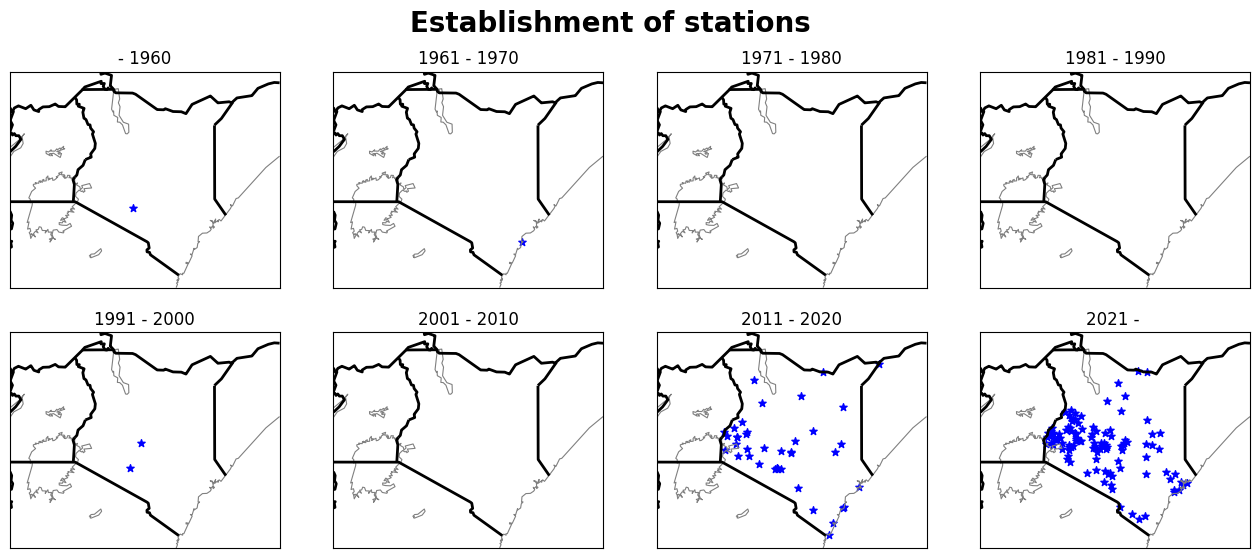

In [124]:
plt.style.use('default')
fig, axes = plt.subplots(2,4, figsize=(16,6.2))

axes = axes.ravel()


start_d = ["1951-01-01", "1961-01-01", "1971-01-01", "1981-01-01", "1991-01-01", "2001-01-01", "2011-01-01", "2021-01-01", "2031-01-01"]

for i, decade in enumerate(["- 1960", "1961 - 1970", "1971 - 1980", "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2020", "2021 - "]):
    
    m = Basemap(projection='lcc', resolution='l', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6,  ax = axes[i]) 

    # map background
    m.drawcoastlines(color='grey', linewidth=0.8)

    m.drawcountries(color='black', linewidth=2)

    df = pd.DataFrame(data["stations"])
    df = df[(df["beginPosition"] >= start_d[i]) & (df["beginPosition"] < start_d[i+1])]

    if not df.empty:
        lat = df["lat"]
        lon = df["lon"]
        m.scatter(lon, lat, latlon=True, c="blue",s=30,marker="*")

    axes[i].set_title(decade)

plt.suptitle('Establishment of stations', fontsize=20, fontweight="bold")

plt.savefig(os.getcwd()+"/Plots/Station_establishment_decade.pdf", bbox_inches='tight')


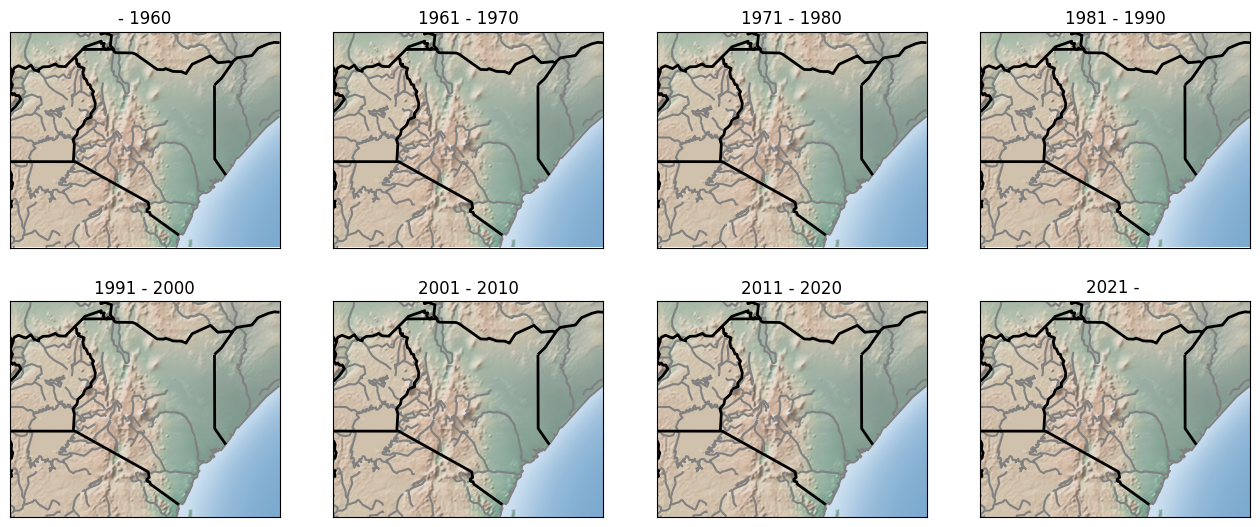

In [56]:
plt.style.use('default')

fig, axs = plt.subplots(2,4,figsize=(16,6.5))
plt.subplots_adjust(hspace=0)
# ax1 = plt.subplot(241)
# ax2 = plt.subplot(242)
# ax3 = plt.subplot(243)
# ax4 = plt.subplot(244)
# ax5 = plt.subplot(245)
# ax6 = plt.subplot(246)
# ax7 = plt.subplot(247)
# ax8 = plt.subplot(248)

ax = axs.ravel()

start_d = ["1951-01-01", "1961-01-01", "1971-01-01", "1981-01-01", "1991-01-01", "2001-01-01", "2011-01-01", "2021-01-01", "2031-01-01"]

for i, decade in enumerate(["- 1960", "1961 - 1970", "1971 - 1980", "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2020", "2021 - "]):
    
    # name = "ax"+str(i)
    # ax = name

    m = Basemap(projection='lcc', resolution='l', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6, ax = ax[i]) 

    # map background
    # m.fillcontinents(color='tan',lake_color='lightblue')
    m.shadedrelief()
    # m.etopo()
    # m.bluemarble()
    # m.drawmapscale(lon=43, lat=-4.7, lon0=43,lat0=-4, length=200, barstyle="fancy", linecolor="black", fillcolor2="black", fontsize=12, fontcolor="black")
    m.drawcoastlines(color='grey', linewidth=1.5)
    m.drawrivers(color='grey', linewidth=1.5)
    m.drawcountries(color='black', linewidth=2)
    # m.drawlsmask(land_color='0.8', ocean_color='w', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5)
    # m.drawmapboundary(color='k', linewidth=1.0, fill_color=None, zorder=None, ax=None)

    ax[i].set_title(decade)
